<a href="https://colab.research.google.com/github/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/blob/main/finalprojectcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading required Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Concatenate, Dense, TimeDistributed, LSTM, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

In [27]:
import numpy as np
import os

# Create the directory
data_dir = '/mnt/data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Loading Dataset

In [3]:
data ='https://raw.githubusercontent.com/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/refs/heads/main/news_summary.csv'

In [4]:
# Attempt to load the dataset with a different encoding
news_data = pd.read_csv(data, encoding='latin1')

# Display the first few rows and the dataset information
news_data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
# This  retriev iing nformation about the data
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


## Preprocessing Part 1

In [8]:
# Drop rows where 'ctext' or 'headlines' have missing values
news_data = news_data.dropna(subset=['ctext', 'headlines'])

In [10]:
news_data.shape

(4396, 6)

In [11]:
# Define a cleaning function to preprocess text
def clean_text(text):
    """
    Removes special characters, extra spaces, and lowercases the text.
    """
    text = text.replace('\n', ' ').replace('\r', ' ')  # Remove line breaks
    text = ''.join(char for char in text if char.isalnum() or char.isspace())  # Remove special characters
    text = ' '.join(text.split())  # Remove extra spaces
    return text.lower()

# Apply cleaning to 'ctext' and 'headlines'
news_data['cleaned_ctext'] = news_data['ctext'].apply(clean_text)
news_data['cleaned_headlines'] = news_data['headlines'].apply(clean_text)


**Tokenization and Word Count**

In [12]:
# Tokenize text and compute word counts
news_data['ctext_word_count'] = news_data['cleaned_ctext'].apply(lambda x: len(x.split()))
news_data['headlines_word_count'] = news_data['cleaned_headlines'].apply(lambda x: len(x.split()))


## Data visualisation

**Word Count Distribution Visualization**

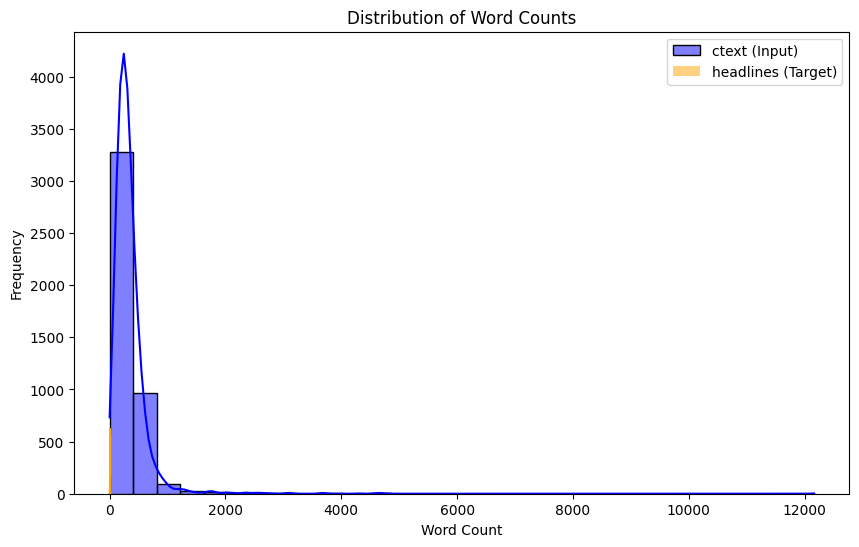

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(news_data['ctext_word_count'], bins=30, kde=True, color='blue', label='ctext (Input)')
sns.histplot(news_data['headlines_word_count'], bins=30, kde=True, color='orange', label='headlines (Target)')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


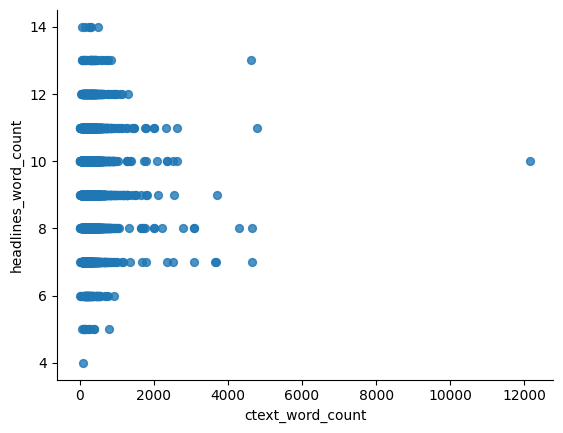

In [16]:
# Plotting ctext_word_count vs headlines_word_count

from matplotlib import pyplot as plt
news_data.plot(kind='scatter', x='ctext_word_count', y='headlines_word_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

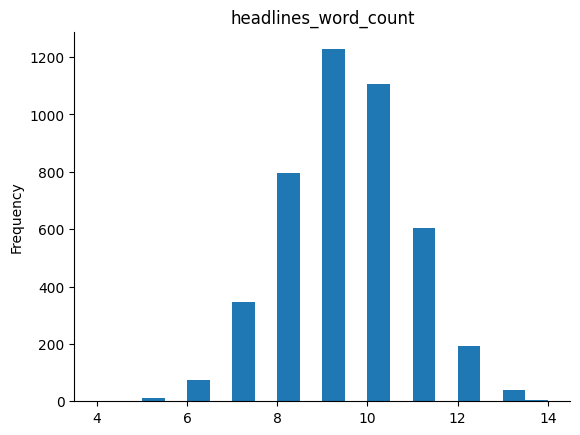

In [19]:
# PLotting headlines_word_count

from matplotlib import pyplot as plt
news_data['headlines_word_count'].plot(kind='hist', bins=20, title='headlines_word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

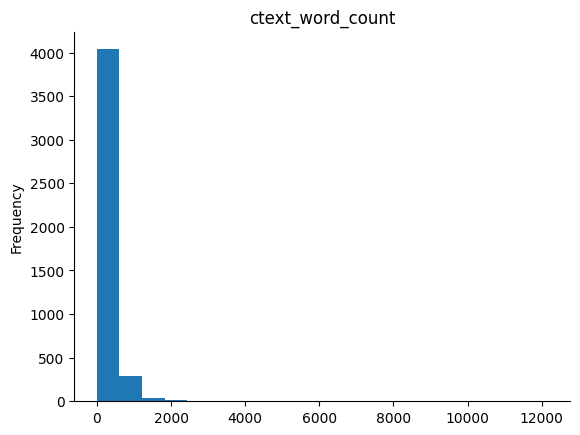

In [20]:
# Plotting ctext_word_count

from matplotlib import pyplot as plt
news_data['ctext_word_count'].plot(kind='hist', bins=20, title='ctext_word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

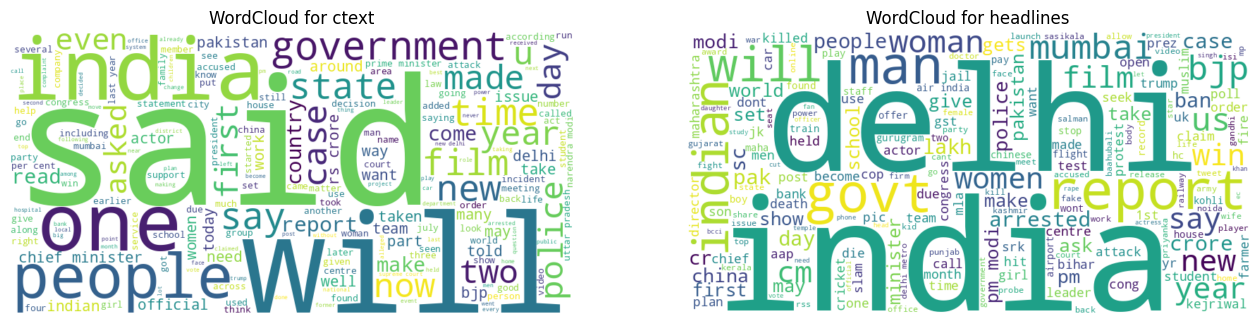

In [21]:
from wordcloud import WordCloud

# Generate WordClouds for 'ctext' and 'headlines'
ctext_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(news_data['cleaned_ctext']))
headlines_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(news_data['cleaned_headlines']))

# Plot WordClouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(ctext_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for ctext')

plt.subplot(1, 2, 2)
plt.imshow(headlines_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for headlines')
plt.show()


## Preprocessing Part 2

**Set Maximum Length for Tokenization**

In [22]:
# Set maximum sequence lengths for ctext and headlines
max_ctext_len = 500  # This was adjusted based on word count distribution
max_headlines_len = 50


**Remove Long Sequences**

In [23]:
# Remove sequences longer than max lengths
filtered_data = news_data[
    (news_data['ctext_word_count'] <= max_ctext_len) &
    (news_data['headlines_word_count'] <= max_headlines_len)
]


**Train-Test Split**

In [24]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_data, val_data = train_test_split(filtered_data, test_size=0.2, random_state=42)


**Tokenization and Padding**

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizers for input and target texts
ctext_tokenizer = Tokenizer()
ctext_tokenizer.fit_on_texts(train_data['cleaned_ctext'])

headlines_tokenizer = Tokenizer()
headlines_tokenizer.fit_on_texts(train_data['cleaned_headlines'])

# Tokenize and pad sequences
x_train = pad_sequences(ctext_tokenizer.texts_to_sequences(train_data['cleaned_ctext']), maxlen=max_ctext_len, padding='post')
x_val = pad_sequences(ctext_tokenizer.texts_to_sequences(val_data['cleaned_ctext']), maxlen=max_ctext_len, padding='post')

y_train = pad_sequences(headlines_tokenizer.texts_to_sequences(train_data['cleaned_headlines']), maxlen=max_headlines_len, padding='post')
y_val = pad_sequences(headlines_tokenizer.texts_to_sequences(val_data['cleaned_headlines']), maxlen=max_headlines_len, padding='post')


**Saving Preprocessed Data**

In [28]:
import numpy as np

# Save the tokenized data
np.save('/mnt/data/x_train.npy', x_train)
np.save('/mnt/data/x_val.npy', x_val)
np.save('/mnt/data/y_train.npy', y_train)
np.save('/mnt/data/y_val.npy', y_val)

# Save the tokenizers for later use
import pickle
with open('/mnt/data/ctext_tokenizer.pkl', 'wb') as f:
    pickle.dump(ctext_tokenizer, f)

with open('/mnt/data/headlines_tokenizer.pkl', 'wb') as f:
    pickle.dump(headlines_tokenizer, f)